## Data Cleaning

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
plt.style.use('ggplot')

In [2]:
#read in
df = pd.read_csv('gofund_final.csv', index_col = False)

df = df.dropna()

df=df.reset_index()

df=df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

df.shares.apply(str)

df.sample(10)

,index,num_of_dons,category,created_date,description,goal,location,shares,title,total_collected
10098,20197,57,Events,"Created June 11, 2018",In celebration of our wonderful coach Denis Mo...,"of $1,000 goal","ROSLYN HEIGHTS, NY",71,Happy 40th Denis,"$2,553"
4054,8109,242,Education,"Created June 7, 2018",OVERVIEW: The HMHS community has been advocati...,"of $93,922 goal","HADDONFIELD, NJ",333,Garang's Education Fund for Emory,"$68,075"
2653,5307,255,Emergencies,"Created September 8, 2018",",Hello Everyone, ,My name is Georgianna Street...","of $20,000 goal","LOS ANGELES, CA",584,Alarcon Family - Cypress Park,"$19,466"
15247,30495,12,Travel,"Created September 21, 2018",",Hello! My name is Karol Carlsen, and I am cur...","of $2,000 goal","LEXINGTON PARK, MD",47,Studying in Rome,"$1,000"
9325,18651,25,Creative,"Created June 30, 2018","A year ago I had an exciting, and possibly cra...","of $2,500 goal","PHILADELPHIA, PA",59,Help Me Launch My First Solo Show!,"$3,200"
10806,21613,18,Events,"Created June 7, 2018",What: CHS Class of 1988: 30-Year Class Reu...,"of $1,500 goal","FORT WORTH, TX",5,CHS Class of 1988- 30 Year Reunion,$870
15708,31417,11,Travel,"Created June 18, 2018",",Hey there, ,My name is Julia and I am startin...","of $1,500 goal","ROCHESTER, NY",42,Zimbabwe,$545
2953,5907,198,Emergencies,"Created October 22, 2018",Sunday the 21st my dad woke up and felt as if ...,"of $20,000 goal","SEMINOLE, FL",1.5k,Momma Spicer's Medical Bills,"$15,630"
136,273,510,Medical,"Created September 26, 2018",Victor Pedrosa foi diagnosticado com um tipo r...,"of $80,000 goal","KEY BISCAYNE, FL",517,Victor Pedrosa Assistencia Medica,"$67,592"
360,721,162,Medical,"Created June 22, 2018",",On June 6, Cathy Roemer suffered a brain aneu...","of $45,000 goal","NOTRE DAME, IN",217,Cathy Roemer Family,"$44,500"


In [3]:
df.shares = np.where(df.shares.str.contains('k'), pd.to_numeric(df.shares.map(lambda x: str(x)[:-1]))*1000,
                     df.shares)

df.goal = df.goal.str.split().str[1]

df.goal=df.goal.str.strip()
df['currency']=df.goal.map(lambda x: str(x)[:1])

In [4]:
cols = ['num_of_dons', 'goal', 'total_collected']
df[cols]=df[cols].apply(lambda x: x.str.replace(',',''))
df[cols]=df[cols].apply(lambda x: x.str.replace('$',''))
df[cols]=df[cols].apply(lambda x: x.str.replace('€',''))
df[cols]=df[cols].apply(lambda x: x.str.replace('kr',''))
df['created_date']=df['created_date'].str.replace('Created','')

In [5]:
df.goal = np.where(df.goal.str.contains('M', na = False), pd.to_numeric(df.goal.map(lambda x: str(x)[:-1]))*1000000, df.goal)
df[df.goal.str.contains('B', na = False)]

df.goal = np.where(df.goal.str.contains('B', na = False), pd.to_numeric(df.goal.map(lambda x: str(x)[:-1]))*1000000000, df.goal)


In [6]:
df.total_collected = df.total_collected.astype(float)
df.goal = df.goal.astype(float)

In [7]:
mons = {'September':'09', 'October':'10', 'November':'11', 'December':'12','January':'01',
       'February':'02', 'March':'03', 'April':'04', 'May':'05', 'June':'06', 'July':'07',
        'August':'08'}


scrape_date = datetime.date(2018, 10, 26)
df.created_date = df.created_date.str.replace(',','')
df.created_date = df.created_date.replace(mons, regex=True)
df.created_date = df.created_date.str.split()
df.created_date = df.created_date.map(lambda x: '/'.join(x))
df.created_date = pd.to_datetime(df.created_date)
df['days_running']= (scrape_date - df.created_date)/np.timedelta64(1, 'D')
df = df[df.currency == '$']
df=df[df.total_collected > df.goal]

In [8]:
#nlp

import re
df.description = df.description.str.lower()
df.description = df.description.apply(lambda x: re.sub('\s+', ' ', x))
df.description = df.description.apply(lambda x: re.sub('[^\w\s]', '', x))
df = df.loc[df.description != ""]

from nltk.corpus import stopwords
stop = stopwords.words('english')

df.description = df.description.apply(lambda x: " ".join(x for x in x.split() if x not in stop))

In [9]:
from textblob import TextBlob

def sentiment_func(x):
    sentiment = TextBlob(x['description'])
    x['polarity'] = sentiment.polarity
    x['subjectivity'] = sentiment.subjectivity
    return x

df = df.apply(sentiment_func, axis=1)

In [10]:
df = df[df.description != '']

In [11]:
df_num_cols = ['category', 'num_of_dons', 'goal', 'shares', 'total_collected', 'days_running', 'polarity', 'subjectivity']
df_num = df[df_num_cols]
df_num.iloc[:,1:8] = df_num.iloc[:,1:8].astype(float)

C:\Users\phili\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


## EDA

In [12]:
round(df_num.iloc[:,1:8].mean(),2)
x = ['num_of_dons', 'goal', 'shares', 'total_collected', 'days_running', 'polarity', 'subjectivity']
df[x] = df[x].astype(float)

Text(0.5,1,'Donations Box')

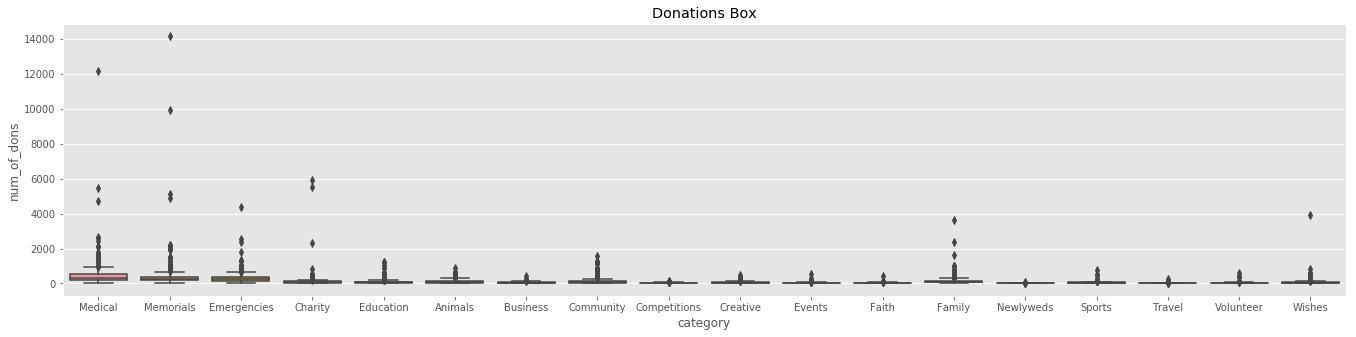

In [13]:
fig, ax = plt.subplots(figsize=(23,5))
x = sns.boxplot(x="category", y="num_of_dons", data=df)
x.set_title('Donations Box')

Text(0.5,1,'Shares Box')

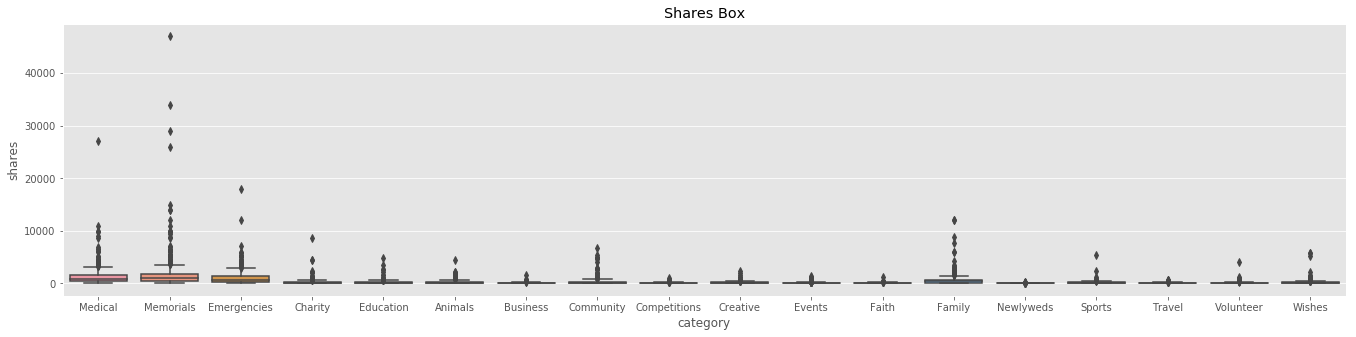

In [14]:
fig, ax = plt.subplots(figsize=(23,5))
x = sns.boxplot(x="category", y="shares", data=df)
x.set_title('Shares Box')

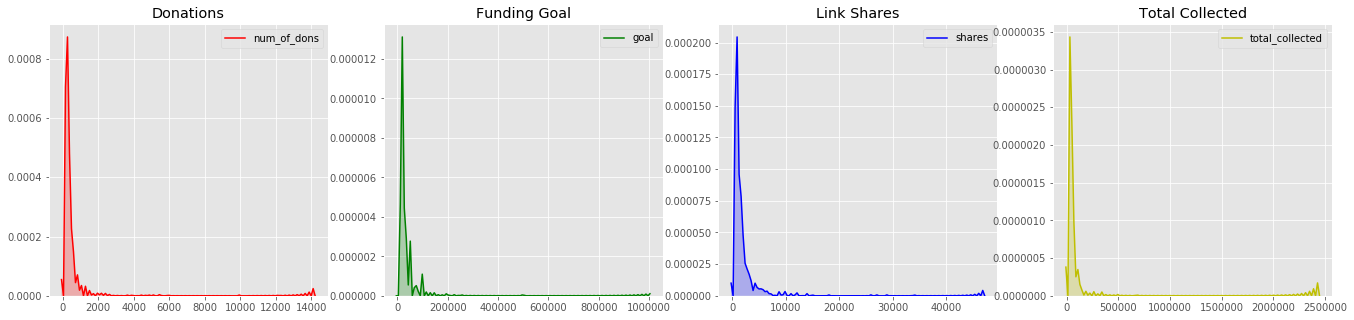

In [15]:
import seaborn as sns

fig, ax =plt.subplots(1,4, figsize=(23,5))

x = sns.kdeplot(df['num_of_dons'], shade = True, ax=ax[0], color="r")
x.set_title("Donations")

y = sns.kdeplot(df['goal'], shade = True, ax=ax[1], color="g")
y.set_title("Funding Goal")

q = sns.kdeplot(df['total_collected'], shade = True, ax=ax[3], color="y")
q.set_title("Total Collected")

z = sns.kdeplot(df['shares'], shade = True, ax=ax[2], color="b")
z.set_title("Link Shares")

plt.show()

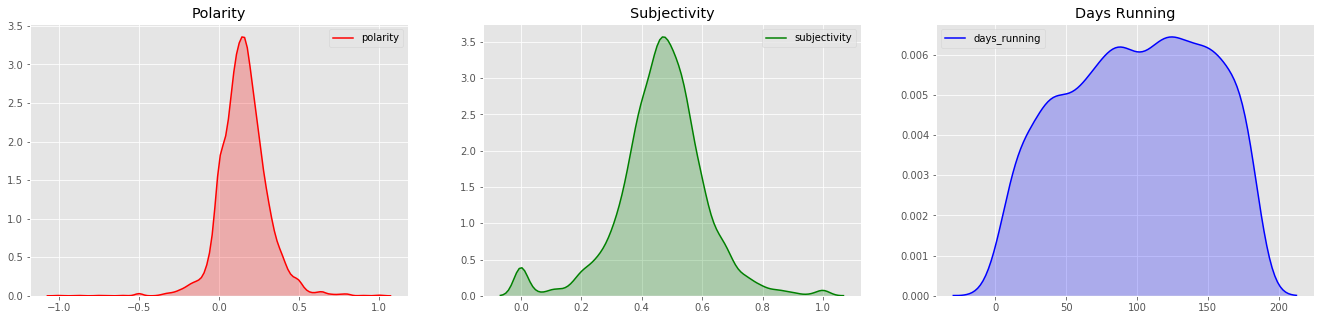

In [16]:
fig, ax =plt.subplots(1,3, figsize=(23,5))

x = sns.kdeplot(df['polarity'], shade = True, ax=ax[0], color="r")
x.set_title("Polarity")

y = sns.kdeplot(df['subjectivity'], shade = True, ax=ax[1], color="g")
y.set_title("Subjectivity")

z = sns.kdeplot(df['days_running'], shade = True, ax=ax[2], color="b")
z.set_title("Days Running")

plt.show()

In [17]:
tolog = ['num_of_dons', 'goal', 'shares', 'total_collected']

df_numl = df_num

df_numl[tolog] = (df_numl[tolog]+1).apply(np.log10)

C:\Users\phili\Anaconda3\lib\site-packages\pandas\core\frame.py:2352: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


Text(0.5,1,'Donations Box(log10)')

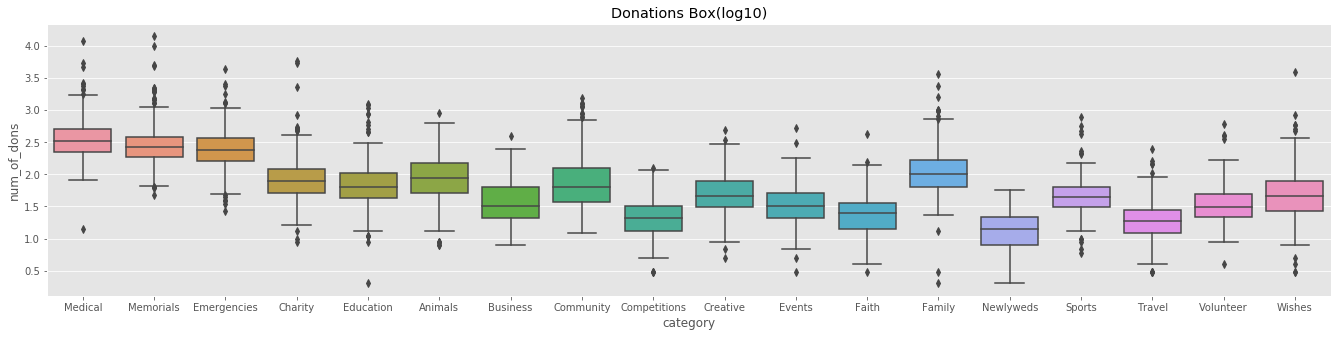

In [18]:
fig, ax = plt.subplots(figsize=(23,5))
x = sns.boxplot(x="category", y="num_of_dons", data=df_numl)
x.set_title('Donations Box(log10)')

Text(0.5,1,'Goal Box(log10)')

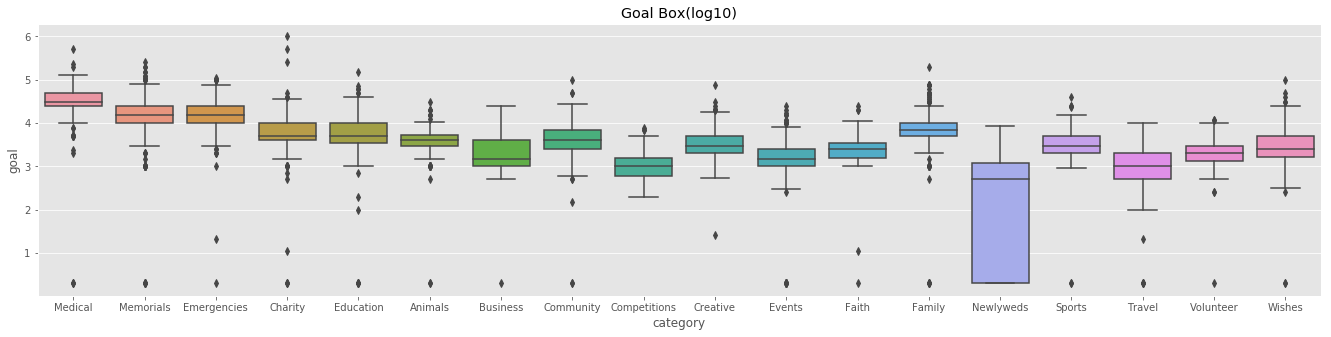

In [19]:
fig, ax = plt.subplots(figsize=(23,5))
x = sns.boxplot(x="category", y="goal", data=df_numl)
x.set_title('Goal Box(log10)')

Text(0.5,1,'Shares Box(log10)')

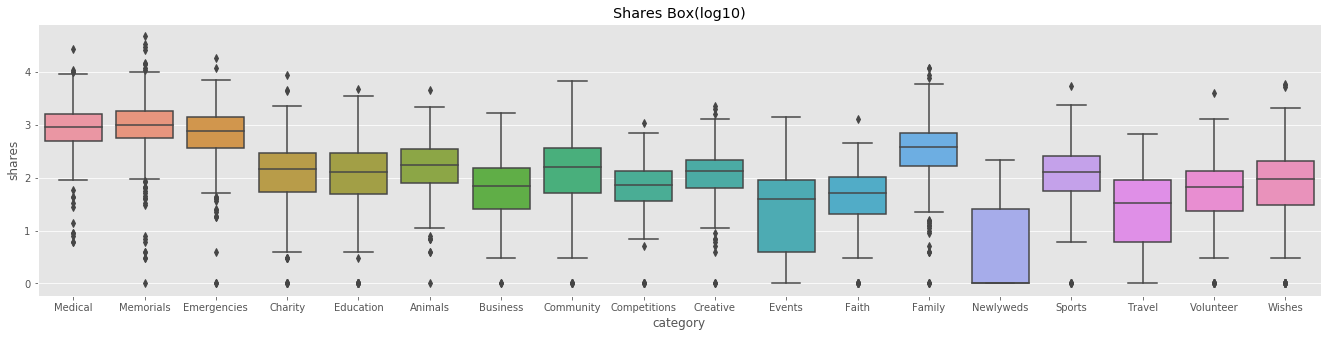

In [20]:
fig, ax = plt.subplots(figsize=(23,5))
x = sns.boxplot(x="category", y="shares", data=df_numl)
x.set_title('Shares Box(log10)')

Text(0.5,1,'Total Collected Box(log10)')

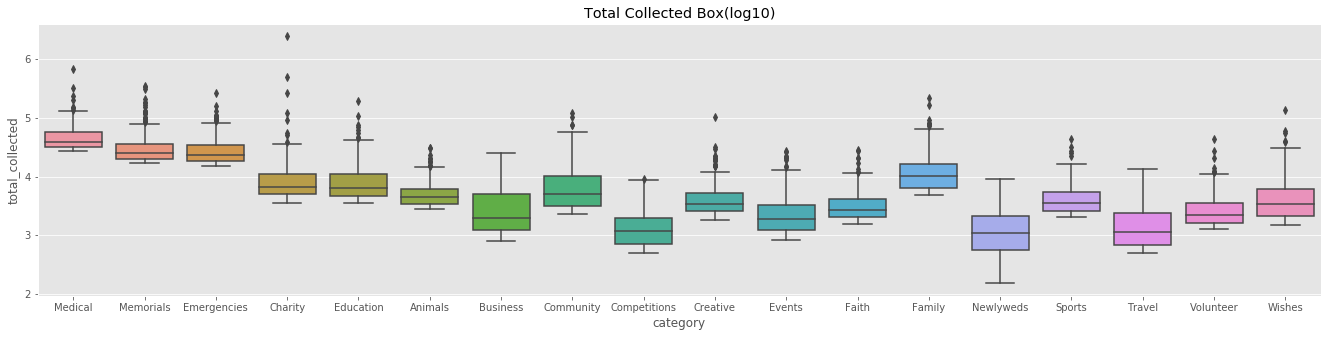

In [21]:
fig, ax = plt.subplots(figsize=(23,5))
x = sns.boxplot(x="category", y="total_collected", data=df_numl)
x.set_title('Total Collected Box(log10)')

Text(0.5,1,'Days Running Box(log10)')

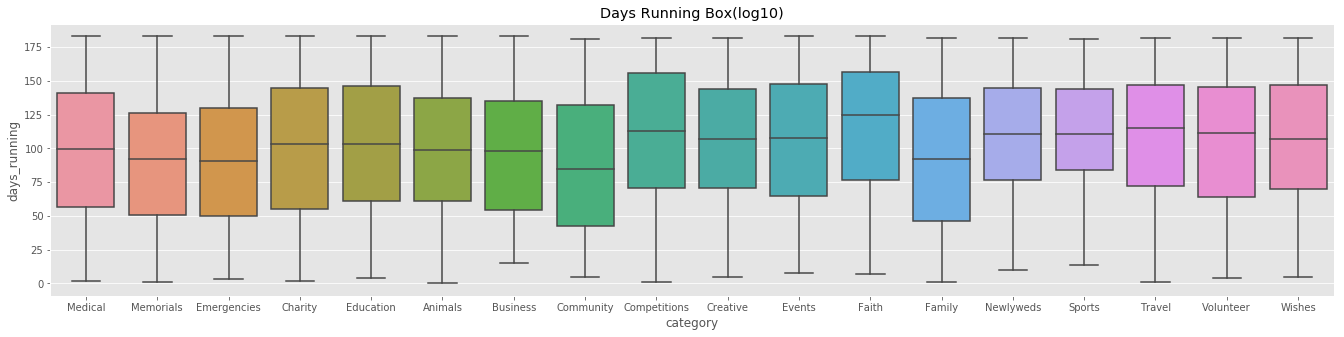

In [22]:
fig, ax = plt.subplots(figsize=(23,5))
x = sns.boxplot(x="category", y="days_running", data=df_numl)
x.set_title('Days Running Box(log10)')

Text(0.5,1,'Polarity SA Box(log10)')

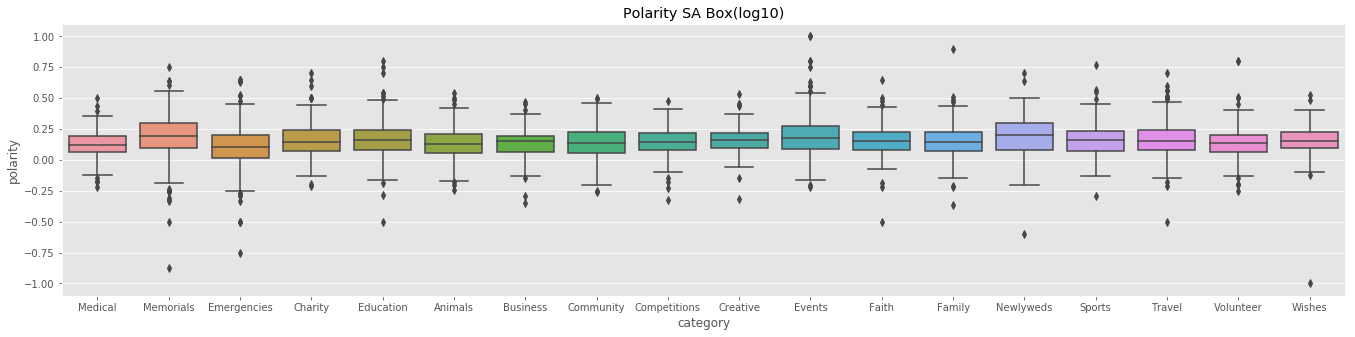

In [23]:
fig, ax = plt.subplots(figsize=(23,5))
x = sns.boxplot(x="category", y="polarity", data=df_numl)
x.set_title('Polarity SA Box(log10)')

Text(0.5,1,'Subjectivity SA Box(log10)')

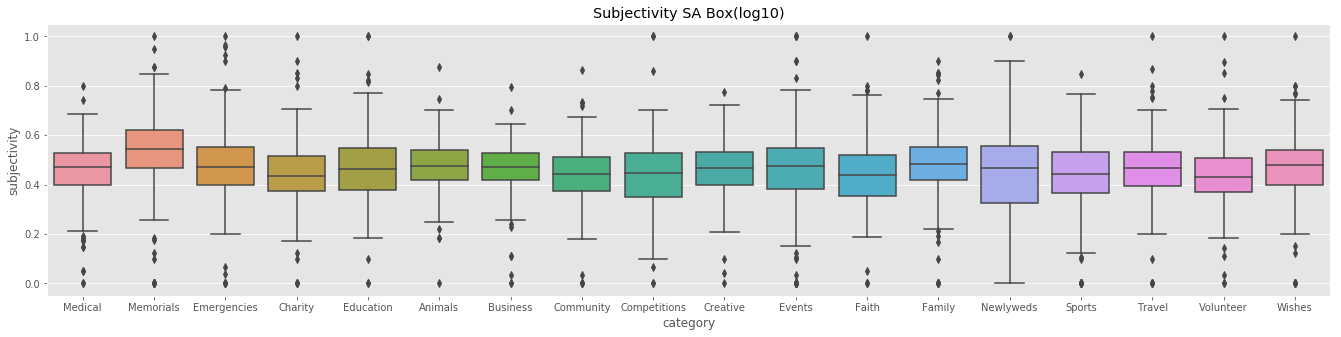

In [24]:
fig, ax = plt.subplots(figsize=(23,5))
x = sns.boxplot(x="category", y="subjectivity", data=df_numl)
x.set_title('Subjectivity SA Box(log10)')

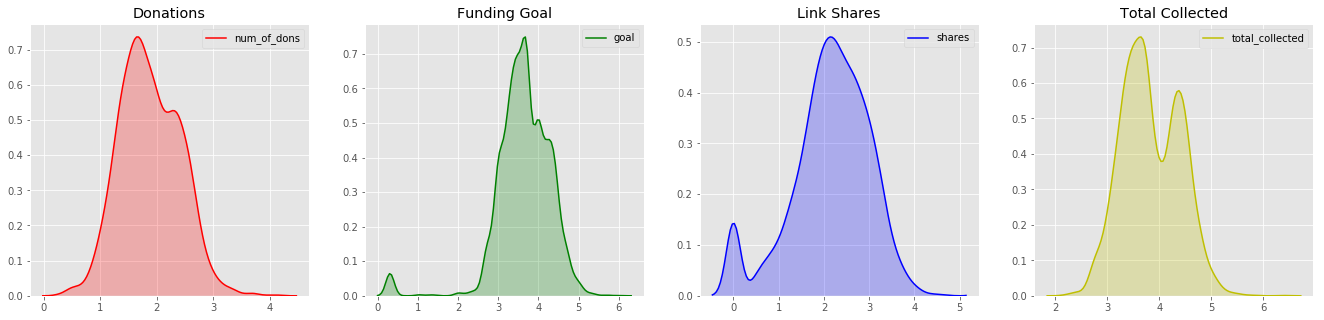

In [25]:
import seaborn as sns

fig, ax =plt.subplots(1,4, figsize=(23,5))

x = sns.kdeplot(df_numl['num_of_dons'], shade = True, ax=ax[0], color="r")
x.set_title("Donations")

y = sns.kdeplot(df_numl['goal'], shade = True, ax=ax[1], color="g")
y.set_title("Funding Goal")

q = sns.kdeplot(df_numl['total_collected'], shade = True, ax=ax[3], color="y")
q.set_title("Total Collected")

z = sns.kdeplot(df_numl['shares'], shade = True, ax=ax[2], color="b")
z.set_title("Link Shares")

plt.show()

In [26]:
df_gro = df_numl.groupby(['category']).agg({'num_of_dons':['mean'],
                                                   'goal':['mean'],
                                                   'shares':['mean'],
                                                   'total_collected':['mean'],
                                                   'days_running':['mean'],
                                                  'polarity': ['mean','max', 'min'],
                                                  'subjectivity':['mean','max', 'min']})


df_gro


num_of_dons      goal    shares total_collected days_running  \
                    mean      mean      mean            mean         mean   
category                                                                    
Animals         1.933012  3.577302  2.198605        3.704639    98.205021   
Business        1.556721  3.282436  1.761202        3.396598    98.094737   
Charity         1.928837  3.738899  2.058752        3.929603   100.167331   
Community       1.868686  3.597206  2.124353        3.787687    88.837209   
Competitions    1.325332  3.042206  1.777234        3.113819   108.896552   
Creative        1.675782  3.518250  2.046749        3.602711   105.313725   
Education       1.829737  3.671528  1.996196        3.901722   103.661017   
Emergencies     2.392917  4.176923  2.798529        4.424529    90.951613   
Events          1.516791  3.137143  1.334181        3.356735   105.120301   
Faith           1.357067  3.386954  1.606478        3.491402   114.706587   
Family          2.032269  3.819227  2.478288        4.069533    92.992958   
Medical         2.548816  4.437647  2.908861        4.658542    97.255102   
Memorials       2.449106  4.147034  2.956017        4.465509    90.089980   
Newlyweds       1.111730  2.216950  0.652349        3.012623   107.852273   
Sports          1.652661  3.507422  1.993414        3.618088   110.756614   
Travel          1.276429  2.952795  1.352988        3.135583   107.867052   
Volunteer       1.521920  3.281439  1.740328        3.416238   103.772000   
Wishes          1.676050  3.460694  1.839785        3.613765   106.429787   

              polarity                     subjectivity                 
                  mean       max       min         mean       max  min  
category                                                                
Animals       0.135051  0.537500 -0.242857     0.476313  0.875000  0.0  
Business      0.128000  0.468182 -0.350000     0.453407  0.795960  0.0  
Charity       0.161436  0.700000 -0.212637     0.441022  1.000000  0.0  
Community     0.143893  0.500000 -0.257500     0.437452  0.863636  0.0  
Competitions  0.146719  0.479167 -0.325000     0.440553  1.000000  0.0  
Creative      0.159992  0.531250 -0.312500     0.464166  0.775000  0.0  
Education     0.171588  0.800000 -0.500000     0.467915  1.000000  0.0  
Emergencies   0.105933  0.650000 -0.750000     0.473927  1.000000  0.0  
Events        0.201652  1.000000 -0.216327     0.454705  1.000000  0.0  
Faith         0.157136  0.650000 -0.500000     0.441132  1.000000  0.0  
Family        0.148800  0.900000 -0.366667     0.479837  0.900000  0.0  
Medical       0.124251  0.500000 -0.220000     0.456755  0.800000  0.0  
Memorials     0.186387  0.750000 -0.875000     0.537614  1.000000  0.0  
Newlyweds     0.189138  0.700000 -0.600000     0.440821  1.000000  0.0  
Sports        0.159680  0.766667 -0.291667     0.429056  0.847917  0.0  
Travel        0.165020  0.700000 -0.500000     0.457025  1.000000  0.0  
Volunteer     0.139077  0.800000 -0.250000     0.435679  1.000000  0.0  
Wishes        0.155882  0.525000 -1.000000     0.468566  1.000000  0.0

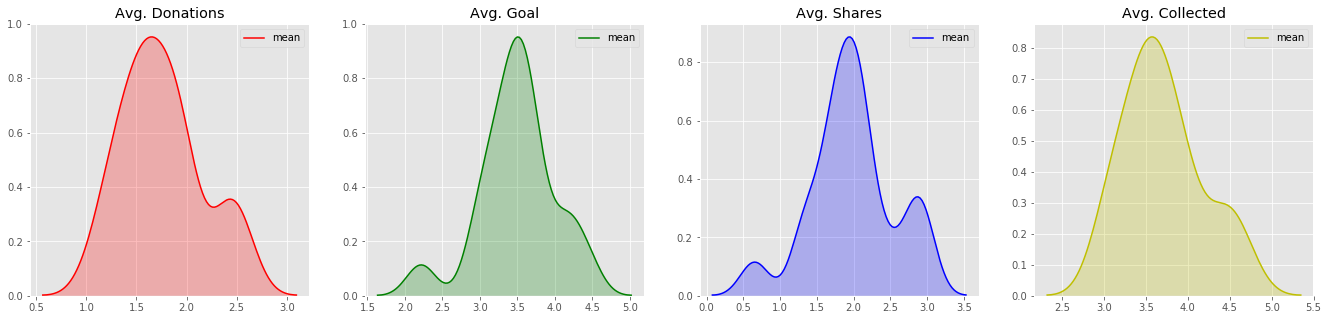

In [27]:
fig, ax =plt.subplots(1,4, figsize=(23,5))

x = sns.kdeplot(df_gro['num_of_dons']['mean'], shade = True, ax=ax[0], color="r")
x.set_title("Avg. Donations")

y = sns.kdeplot(df_gro['goal']['mean'], shade = True, ax=ax[1], color="g")
y.set_title("Avg. Goal")

q = sns.kdeplot(df_gro['total_collected']['mean'], shade = True, ax=ax[3], color="y")
q.set_title("Avg. Collected")

z = sns.kdeplot(df_gro['shares']['mean'], shade = True, ax=ax[2], color="b")
z.set_title("Avg. Shares")

plt.show()


## Statistical Inference

In [28]:
#3 Category f-test
from scipy.stats import f_oneway

welfare = ['Charity', 'Emergencies', 'Medical']

other = ['Animals', 'Business', 'Community', 'Competitions',
       'Creative', 'Education', 'Events', 'Faith', 'Family',
        'Memorials', 'Newlyweds', 'Sports', 'Travel', 'Volunteer',
        'Wishes']

var = df_numl.columns[1:]

ANOV = []
for i in var:
    test = df_numl['%s' % i][df_numl.category.isin(welfare)]
    against = df_numl['%s' % i][df_numl.category.isin(other)]
    
    ANOV.append(f_oneway(test,against))
    
ANOV



[F_onewayResult(statistic=855.83063585136574, pvalue=3.9105946683177245e-171),
 F_onewayResult(statistic=646.74254260803662, pvalue=1.1520897296779526e-132),
 F_onewayResult(statistic=357.9688052746244, pvalue=1.251019383214728e-76),
 F_onewayResult(statistic=1216.9596436914123, pvalue=6.6747479398554854e-234),
 F_onewayResult(statistic=7.9047245969826498, pvalue=0.0049538500248578346),
 F_onewayResult(statistic=35.53625754345186, pvalue=2.712735442135702e-09),
 F_onewayResult(statistic=2.8184922816248159, pvalue=0.093259580621872229)]

In [29]:
for i in range(len(ANOV)):
    ANOV[i] = ANOV[i][1]
    
ANOV = pd.Series(ANOV)
ANOV.index = ['num_of_dons', 'goal', 'shares', 'total_collected', 'days_running', 'polarity', 'subjectivity']
ANOV

num_of_dons        3.910595e-171
goal               1.152090e-132
shares              1.251019e-76
total_collected    6.674748e-234
days_running        4.953850e-03
polarity            2.712735e-09
subjectivity        9.325958e-02
dtype: float64

In [30]:
#2 Category f-test
welfare = ['Charity', 'Medical']

other = [ 'Emergencies','Animals', 'Business', 'Community', 'Competitions',
       'Creative', 'Education', 'Events', 'Faith', 'Family',
        'Memorials', 'Newlyweds', 'Sports', 'Travel', 'Volunteer',
        'Wishes']

var = df_numl.columns[1:]

ANOV = []
for i in var:
    test = df_numl['%s' % i][df_numl.category.isin(welfare)]
    against = df_numl['%s' % i][df_numl.category.isin(other)]
    
    ANOV.append(f_oneway(test,against))
    
ANOV

[F_onewayResult(statistic=355.8253915168429, pvalue=3.3639945702217678e-76),
 F_onewayResult(statistic=320.57030559276217, pvalue=4.2028082618933891e-69),
 F_onewayResult(statistic=122.23403654244756, pvalue=5.0556650885093462e-28),
 F_onewayResult(statistic=533.08648814908247, pvalue=4.935079239089129e-111),
 F_onewayResult(statistic=0.54054927567634115, pvalue=0.4622469450107568),
 F_onewayResult(statistic=5.4002400073681383, pvalue=0.020182295070372898),
 F_onewayResult(statistic=7.9176918836982288, pvalue=0.0049185362853952294)]

In [31]:
for i in range(len(ANOV)):
    ANOV[i] = ANOV[i][1]
    
ANOV = pd.Series(ANOV)
ANOV.index = ['num_of_dons', 'goal', 'shares', 'total_collected', 'days_running', 'polarity', 'subjectivity']
ANOV

num_of_dons         3.363995e-76
goal                4.202808e-69
shares              5.055665e-28
total_collected    4.935079e-111
days_running        4.622469e-01
polarity            2.018230e-02
subjectivity        4.918536e-03
dtype: float64

In [32]:
#1 Category f-test
welfare = [ 'Medical']

other = [ 'Charity', 'Emergencies','Animals', 'Business', 'Community', 'Competitions',
       'Creative', 'Education', 'Events', 'Faith', 'Family',
        'Memorials', 'Newlyweds', 'Sports', 'Travel', 'Volunteer',
        'Wishes']

var = df_numl.columns[1:]

ANOV = []
for i in var:
    test = df_numl['%s' % i][df_numl.category.isin(welfare)]
    against = df_numl['%s' % i][df_numl.category.isin(other)]
    
    ANOV.append(f_oneway(test,against))
    
ANOV

[F_onewayResult(statistic=572.15062152533403, pvalue=1.5797984035801922e-118),
 F_onewayResult(statistic=466.22421095713071, pvalue=4.6848053224012666e-98),
 F_onewayResult(statistic=265.38355639501538, pvalue=7.0993581726830692e-58),
 F_onewayResult(statistic=823.23994057125162, pvalue=3.021265609024487e-165),
 F_onewayResult(statistic=1.0119583335565239, pvalue=0.31449310135914293),
 F_onewayResult(statistic=14.016006329640891, pvalue=0.00018372968055457809),
 F_onewayResult(statistic=1.2249628303718749, pvalue=0.26845337994728924)]

In [33]:
for i in range(len(ANOV)):
    ANOV[i] = ANOV[i][1]
    
ANOV = pd.Series(ANOV)
ANOV.index = ['num_of_dons', 'goal', 'shares', 'total_collected', 'days_running', 'polarity', 'subjectivity']
ANOV

num_of_dons        1.579798e-118
goal                4.684805e-98
shares              7.099358e-58
total_collected    3.021266e-165
days_running        3.144931e-01
polarity            1.837297e-04
subjectivity        2.684534e-01
dtype: float64

In [32]:
from scipy.stats import ttest_ind

Donations_t = pd.DataFrame(index = df_gro.index, columns = df_gro.index)
Goal_t = pd.DataFrame(index = df_gro.index, columns = df_gro.index)
Shares_t = pd.DataFrame(index = df_gro.index, columns = df_gro.index)
Collected_t = pd.DataFrame(index = df_gro.index, columns = df_gro.index)
Days_t = pd.DataFrame(index = df_gro.index, columns = df_gro.index)
Pol_t = pd.DataFrame(index = df_gro.index, columns = df_gro.index)
Subj_t = pd.DataFrame(index = df_gro.index, columns = df_gro.index)

dt = [Donations_t, Goal_t, Shares_t, Collected_t, Days_t, Pol_t, Subj_t]

cats = sorted(df_numl.category.unique())
var = df_numl.columns[1:]


z = -1
for k in var:
    z += 1
    x = -1
    for i in cats:
        x += 1
        y = -1
        for j in cats:
            y += 1
            
            test = df_numl['%s' % k][df_numl.category == '%s' % i]
            against=df_numl['%s' % k][df_numl.category == '%s' % j]
            
            dt[z].iloc[x,y] = ttest_ind(test, against) 

category,Animals,Business,Charity,Community,Competitions,Creative,Education,Emergencies,Events,Faith,Family,Medical,Memorials,Newlyweds,Sports,Travel,Volunteer,Wishes
category,,,,,,,,,,,,,,,,,,
Animals,"(0.0, 1.0)","(9.43428251401, 7.09376483978e-19)","(-8.57024415329, 1.36826997656e-16)","(-2.97936067826, 0.00304409253048)","(22.3995892909, 1.44098707713e-71)","(4.34384464624, 1.73908285142e-05)","(-7.9495331135, 1.3861759185e-14)","(-38.9395451169, 8.06781986494e-160)","(13.6079700857, 3.94888768816e-36)","(8.89377614862, 1.99434343808e-17)","(-15.0134805977, 1.34226976156e-42)","(-52.3327879001, 9.7169127605e-212)","(-44.3849503133, 5.08756811748e-209)","(20.4157863536, 3.37938460229e-60)","(3.72024770739, 0.000225675710963)","(20.9261872124, 1.11498282694e-66)","(13.1092129016, 7.68830348404e-34)","(3.41313757581, 0.000697495225622)"
Business,"(-9.43428251401, 7.09376483978e-19)","(0.0, 1.0)","(-12.4339013068, 1.44291651704e-29)","(-8.58152251739, 4.68349256243e-16)","(6.43454528099, 6.74588011295e-10)","(-5.29926581058, 2.27047028594e-07)","(-12.4099118329, 2.86423093378e-29)","(-33.4774249668, 1.89617823853e-118)","(0.954966859873, 0.340237040578)","(-2.36829561508, 0.0186020937653)","(-16.9422785797, 2.82322654857e-48)","(-41.529826999, 1.13813552421e-144)","(-37.9914900176, 9.84949498649e-160)","(6.79351892686, 1.52399692102e-10)","(-5.71990986214, 2.71640824182e-08)","(5.8186203925, 1.70062003954e-08)","(-0.540306666516, 0.589336208326)","(-4.98907826573, 9.85959242141e-07)"
Charity,"(8.57024415329, 1.36826997656e-16)","(12.4339013068, 1.44291651704e-29)","(0.0, 1.0)","(4.27367558112, 2.33462006117e-05)","(23.5404409152, 3.86837623813e-77)","(10.8555685396, 1.47168010916e-24)","(0.921318162768, 0.357342390992)","(-20.6046548184, 1.33116590071e-70)","(18.9325614305, 4.57759871974e-61)","(13.7557098988, 9.45953071059e-36)","(-4.83656533556, 1.73138566291e-06)","(-30.2258241639, 1.93367972547e-118)","(-25.5734739989, 8.72486749661e-104)","(20.5972392296, 1.35641056712e-61)","(10.2243046309, 3.77918471702e-22)","(23.3605569946, 4.57909971298e-78)","(18.4661208873, 2.06960433214e-58)","(9.95330199461, 2.33568144716e-21)"
Community,"(2.97936067826, 0.00304409253048)","(8.58152251739, 4.68349256243e-16)","(-4.27367558112, 2.33462006117e-05)","(0.0, 1.0)","(18.2926366182, 3.00451864343e-53)","(5.77324375719, 1.52035571349e-08)","(-3.53363683068, 0.00045236607605)","(-24.9329131562, 5.24340436261e-91)","(13.3356148249, 1.00430164163e-34)","(8.75370647033, 6.85485840123e-17)","(-9.1242962606, 1.80212054891e-18)","(-33.9839213106, 8.3868533963e-133)","(-30.3366804338, 8.09470307838e-130)","(16.3757226233, 1.53148283962e-43)","(5.23604277358, 2.65053953248e-07)","(18.0096030065, 4.51802768766e-53)","(12.5494787464, 2.67881990878e-31)","(5.13368777271, 4.24360981241e-07)"
Competitions,"(-22.3995892909, 1.44098707713e-71)","(-6.43454528099, 6.74588011295e-10)","(-23.5404409152, 3.86837623813e-77)","(-18.2926366182, 3.00451864343e-53)","(0.0, 1.0)","(-15.5570058203, 8.96152559591e-42)","(-23.9491070017, 7.47818434934e-78)","(-52.8247797687, 9.31215111018e-196)","(-7.19826608429, 2.94165190542e-12)","(-11.678032229, 2.33156843371e-26)","(-29.7629457153, 3.38879081174e-106)","(-62.9172138889, 3.55081055969e-221)","(-59.4233205232, 6.7126196855e-261)","(2.21780272454, 0.027541998316)","(-16.1202897183, 1.37483388278e-43)","(-0.600450362351, 0.548636516441)","(-10.2950150582, 3.63449738234e-22)","(-14.2082635766, 5.19642633503e-37)"
Creative,"(-4.34384464624, 1.73908285142e-05)","(5.29926581058, 2.27047028594e-07)","(-10.8555685396, 1.47168010916e-24)","(-5.77324375719, 1.52035571349e-08)","(15.5570058203, 8.96152559591e-42)","(0.0, 1.0)","(-10.4043552244, 8.36616706148e-23)","(-37.4769971838, 7.30567750676e-149)","(8.38935945904, 5.82005581771e-16)","(3.87964046861, 0.000123871047794)","(-16.715356604, 6.96590964334e-50)","(-48.4919811085, 2.33806595668e-190)","(-43.4003729701, 1.54725227577e-199)","(14.6116746661, 1.29516656886e-36)",

In [34]:
from statsmodels.stats.multitest import multipletests


p_Donations_t = pd.DataFrame(index = df_gro.index, columns = df_gro.index)
p_Goal_t = pd.DataFrame(index = df_gro.index, columns = df_gro.index)
p_Shares_t = pd.DataFrame(index = df_gro.index, columns = df_gro.index)
p_Collected_t = pd.DataFrame(index = df_gro.index, columns = df_gro.index)
p_Days_t = pd.DataFrame(index = df_gro.index, columns = df_gro.index)
p_Pol_t = pd.DataFrame(index = df_gro.index, columns = df_gro.index)
p_Subj_t = pd.DataFrame(index = df_gro.index, columns = df_gro.index)

p_dt = [p_Donations_t, p_Goal_t, p_Shares_t, p_Collected_t, p_Days_t, p_Pol_t, p_Subj_t]

for x in range(7):
    for i in range(18):
        for j in range(18):
            p_dt[x].iloc[i,j] = dt[x].iloc[i,j][1]
        

    pval = multipletests(p_dt[x].values.flatten(), alpha = .05, method = 'b')
    y = pval[1]
    p_dt[x]= pd.DataFrame(np.array(y).reshape(18,18), index = cats, columns = cats)
    
p_dt[3]


,Animals,Business,Charity,Community,Competitions,Creative,Education,Emergencies,Events,Faith,Family,Medical,Memorials,Newlyweds,Sports,Travel,Volunteer,Wishes
Animals,1,2.29838e-16,4.43319e-14,0.986286,4.6688e-69,0.00563463,4.49121e-12,2.61397e-157,1.27944e-33,6.46167e-15,4.34895e-40,3.14828e-209,1.64837e-206,1.09492e-57,0.0731189,3.61254e-64,2.49101e-31,0.225988
Business,2.29838e-16,1,4.67505e-27,1.51745e-13,2.18567e-07,7.35632e-05,9.28011e-27,6.14362e-116,1,1,9.14725e-46,3.68756e-142,3.19124e-157,4.93775e-08,8.80116e-06,5.51001e-06,1,0.000319451
Charity,4.43319e-14,4.67505e-27,1,0.00756417,1.25335e-74,4.76824e-22,1,4.31298e-68,1.48314e-58,3.06489e-33,0.000560969,6.26512e-116,2.82686e-101,4.39477e-59,1.22446e-19,1.48363e-75,6.70552e-56,7.56761e-19
Community,0.986286,1.51745e-13,0.00756417,1,9.73464e-51,4.92595e-06,0.146567,1.69886e-88,3.25394e-32,2.22097e-14,5.83887e-16,2.71734e-130,2.62268e-127,4.962e-41,8.58775e-05,1.46384e-50,8.67938e-29,0.000137493
Competitions,4.6688e-69,2.18567e-07,1.25335e-74,9.73464e-51,1,2.90353e-39,2.42293e-75,3.01714e-193,9.53095e-10,7.55428e-24,1.09797e-103,1.15046e-218,2.17489e-258,1,4.45446e-41,1,1.17758e-19,1.68364e-34
Creative,0.00563463,7.35632e-05,4.76824e-22,4.92595e-06,2.90353e-39,1,2.71064e-20,2.36704e-146,1.8857e-13,0.0401342,2.25695e-47,7.57533e-188,5.0131e-197,4.19634e-34,1,2.09148e-36,7.14321e-10,1
Education,4.49121e-12,9.28011e-27,1,0.146567,2.42293e-75,2.71064e-20,1,4.10711e-79,4.25525e-56,2.1181e-32,1.44999e-06,2.0088e-128,3.96687e-114,6.63448e-60,4.67973e-18,3.78449e-75,2.05186e-54,1.27317e-16
Emergencies,2.61397e-157,6.14362e-116,4.31298e-68,1.69886e-88,3.01714e-193,2.36704e-146,4.10711e-79,1,1.10376e-190,1.49764e-156,2.34028e-45,1.70606e-34,1,5.61159e-153,7.38236e-142,6.17019e-194,8.82682e-203,1.95301e-130
Events,1.27944e-33,1,1.48314e-58,3.25394e-32,9.53095e-10,1.8857e-13,4.25525e-56,1.10376e-190,1,0.00573815,1.02225e-91,1.458e-226,2.32644e-260,9.02125e-12,8.78717e-15,2.30865e-08,1,2.67424e-13
Faith,6.46167e-15,1,3.06489e-33,2.22097e-14,7.55428e-24,0.0401342,2.1181e-32,1.49764e-156,0.00573815,1,1.02259e-59,1.0691e-192,5.78592e-208,1.86796e-22,0.00382776,8.5745e-21,1,0.0574443


In [35]:
from scipy.stats import f_oneway

Donations_f = pd.DataFrame(index = df_gro.index, columns = df_gro.index)
Goal_f = pd.DataFrame(index = df_gro.index, columns = df_gro.index)
Shares_f = pd.DataFrame(index = df_gro.index, columns = df_gro.index)
Collected_f = pd.DataFrame(index = df_gro.index, columns = df_gro.index)
Days_f = pd.DataFrame(index = df_gro.index, columns = df_gro.index)
Pol_f = pd.DataFrame(index = df_gro.index, columns = df_gro.index)
Subj_f = pd.DataFrame(index = df_gro.index, columns = df_gro.index)


dsf = [Donations_f, Goal_f, Shares_f, Collected_f, Days_f, Pol_f, Subj_f]

cats = sorted(df_numl.category.unique())
var = df_numl.columns[1:]


z = -1
for k in var:
    z += 1
    x = -1
    for i in cats:
        x += 1
        y = -1
        for j in cats:
            y += 1
            
            test = df_numl['%s' % k][df_numl.category == '%s' % i]
            against=df_numl['%s' % k][df_numl.category == '%s' % j]
            
            dsf[z].iloc[x,y] = f_oneway(test, against)

            
dsf[3]

category,Animals,Business,Charity,Community,Competitions,Creative,Education,Emergencies,Events,Faith,Family,Medical,Memorials,Newlyweds,Sports,Travel,Volunteer,Wishes
category,,,,,,,,,,,,,,,,,,
Animals,"(0.0, 1.0)","(89.0056865541, 7.09376483978e-19)","(73.449084847, 1.36826997656e-16)","(8.87659005113, 0.00304409253048)","(501.741600401, 1.44098707713e-71)","(18.8689863107, 1.73908285142e-05)","(63.1950767226, 1.3861759185e-14)","(1516.28817391, 8.06781986494e-160)","(185.176849854, 3.94888768816e-36)","(79.0992541818, 1.99434343808e-17)","(225.404599657, 1.34226976156e-42)","(2738.7206894, 9.7169127605e-212)","(1970.02381431, 5.08756811748e-209)","(416.804332435, 3.37938460229e-60)","(13.8402430044, 0.000225675710963)","(437.905311248, 1.11498282694e-66)","(171.851462899, 7.68830348404e-34)","(11.6495081114, 0.000697495225621)"
Business,"(89.0056865541, 7.09376483978e-19)","(0.0, 1.0)","(154.601901707, 1.44291651704e-29)","(73.6425287164, 4.68349256243e-16)","(41.4033729732, 6.74588011295e-10)","(28.0822181312, 2.27047028594e-07)","(154.005911699, 2.86423093378e-29)","(1120.7379824, 1.89617823853e-118)","(0.911961703456, 0.340237040578)","(5.6088241204, 0.0186020937653)","(287.040803472, 2.82322654857e-48)","(1724.72653057, 1.13813552421e-144)","(1443.35331376, 9.84949498649e-160)","(46.1518994096, 1.52399692102e-10)","(32.717368831, 2.71640824182e-08)","(33.856343272, 1.70062003954e-08)","(0.291931293882, 0.589336208326)","(24.8909019416, 9.85959242141e-07)"
Charity,"(73.449084847, 1.36826997656e-16)","(154.601901707, 1.44291651704e-29)","(-5.80199828066e-30, nan)","(18.2643029726, 2.33462006117e-05)","(554.152358483, 3.86837623813e-77)","(117.843368317, 1.47168010916e-24)","(0.848827157046, 0.357342390992)","(424.551800187, 1.33116590071e-70)","(358.441882321, 4.57759871974e-61)","(189.219554821, 9.45953071059e-36)","(23.3923642451, 1.73138566291e-06)","(913.600446388, 1.93367972547e-118)","(654.002572372, 8.72486749661e-104)","(424.246263883, 1.35641056712e-61)","(104.536405186, 3.77918471702e-22)","(545.715623099, 4.57909971298e-78)","(340.997620624, 2.06960433214e-58)","(99.0682205959, 2.33568144716e-21)"
Community,"(8.87659005113, 0.00304409253048)","(73.6425287164, 4.68349256243e-16)","(18.2643029726, 2.33462006117e-05)","(3.01932969135e-29, 1.0)","(334.620554446, 3.00451864343e-53)","(33.33034348, 1.52035571349e-08)","(12.4865892511, 0.000452366076049)","(621.650158456, 5.24340436261e-91)","(177.838622758, 1.00430164163e-34)","(76.6273769687, 6.85485840123e-17)","(83.2527822512, 1.80212054891e-18)","(1154.90690764, 8.3868533963e-133)","(920.314179741, 8.09470307838e-130)","(268.164291436, 1.53148283962e-43)","(27.4161439267, 2.65053953248e-07)","(324.345800452, 4.51802768766e-53)","(157.489416806, 2.67881990878e-31)","(26.3547501476, 4.24360981241e-07)"
Competitions,"(501.741600401, 1.44098707713e-71)","(41.4033729732, 6.74588011295e-10)","(554.152358483, 3.86837623813e-77)","(334.620554446, 3.00451864343e-53)","(-4.76498262012e-31, nan)","(242.020430093, 8.96152559592e-42)","(573.559726181, 7.47818434934e-78)","(2790.45735761, 9.31215111017e-196)","(51.8150346203, 2.94165190542e-12)","(136.376436742, 2.33156843371e-26)","(885.83293765, 3.38879081174e-106)","(3958.57580354, 3.55081055969e-221)","(3531.13102201, 6.7126196855e-261)","(4.918648925, 0.027541998316)","(259.863740603, 1.37483388278e-43)","(0.360540637647, 0.548636516441)","(105.987335048, 3.63449738234e-22)","(201.874753862, 5.19642633503e-37)"
Creative,"(18.8689863107, 1.73908285142e-05)","(28.0822181312, 2.27047028594e-07)","(117.843368317, 1.47168010916e-24)","(33.33034348, 1.52035571349e-08)","(242.020430093, 8.96152559592e-42)","(7.50794987763e-30, 1.0)","(108.250607637, 8.36616706148e-23)","(1404.52531791, 7.30567750676e-149)","(70.381352133, 5.82005581771e-16)","(15.0516101657, 0.000123871047794)","(279.403146399, 6.96590964334e-50)","(2351.47223183, 2.33806595668e-190)","(1883.59237395, 1.54725227577e-199)","(213.501036547, 1.29516656886e-36)","(0.

In [36]:
from statsmodels.stats.multitest import multipletests


p_Donations_f = pd.DataFrame(index = df_gro.index, columns = df_gro.index)
p_Goal_f = pd.DataFrame(index = df_gro.index, columns = df_gro.index)
p_Shares_f = pd.DataFrame(index = df_gro.index, columns = df_gro.index)
p_Collected_f = pd.DataFrame(index = df_gro.index, columns = df_gro.index)
p_Days_f = pd.DataFrame(index = df_gro.index, columns = df_gro.index)
p_Pol_f = pd.DataFrame(index = df_gro.index, columns = df_gro.index)
p_Subj_f = pd.DataFrame(index = df_gro.index, columns = df_gro.index)

p_dsf = [p_Donations_f, p_Goal_f, p_Shares_f, p_Collected_f, p_Days_f, p_Pol_f, p_Subj_f]

for x in range(7):
    for i in range(18):
        for j in range(18):
            p_dsf[x].iloc[i,j] = dsf[x].iloc[i,j][1]
            
p_dsf[3]

category,Animals,Business,Charity,Community,Competitions,Creative,Education,Emergencies,Events,Faith,Family,Medical,Memorials,Newlyweds,Sports,Travel,Volunteer,Wishes
category,,,,,,,,,,,,,,,,,,
Animals,1,7.09376e-19,1.36827e-16,0.00304409,1.44099e-71,1.73908e-05,1.38618e-14,8.06782e-160,3.94889e-36,1.99434e-17,1.34227e-42,9.71691e-212,5.08757e-209,3.37938e-60,0.000225676,1.11498e-66,7.6883e-34,0.000697495
Business,7.09376e-19,1,1.44292e-29,4.68349e-16,6.74588e-10,2.27047e-07,2.86423e-29,1.89618e-118,0.340237,0.0186021,2.82323e-48,1.13814e-144,9.84949e-160,1.524e-10,2.71641e-08,1.70062e-08,0.589336,9.85959e-07
Charity,1.36827e-16,1.44292e-29,NaN,2.33462e-05,3.86838e-77,1.47168e-24,0.357342,1.33117e-70,4.5776e-61,9.45953e-36,1.73139e-06,1.93368e-118,8.72487e-104,1.35641e-61,3.77918e-22,4.5791e-78,2.0696e-58,2.33568e-21
Community,0.00304409,4.68349e-16,2.33462e-05,1,3.00452e-53,1.52036e-08,0.000452366,5.2434e-91,1.0043e-34,6.85486e-17,1.80212e-18,8.38685e-133,8.0947e-130,1.53148e-43,2.65054e-07,4.51803e-53,2.67882e-31,4.24361e-07
Competitions,1.44099e-71,6.74588e-10,3.86838e-77,3.00452e-53,NaN,8.96153e-42,7.47818e-78,9.31215e-196,2.94165e-12,2.33157e-26,3.38879e-106,3.55081e-221,6.71262e-261,0.027542,1.37483e-43,0.548637,3.6345e-22,5.19643e-37
Creative,1.73908e-05,2.27047e-07,1.47168e-24,1.52036e-08,8.96153e-42,1,8.36617e-23,7.30568e-149,5.82006e-16,0.000123871,6.96591e-50,2.33807e-190,1.54725e-199,1.29517e-36,0.578896,6.4552e-39,2.20469e-12,0.718153
Education,1.38618e-14,2.86423e-29,0.357342,0.000452366,7.47818e-78,8.36617e-23,NaN,1.26763e-81,1.31335e-58,6.53735e-35,4.47527e-09,6.2e-131,1.22434e-116,2.04768e-62,1.44436e-20,1.16805e-77,6.33291e-57,3.92953e-19
Emergencies,8.06782e-160,1.89618e-118,1.33117e-70,5.2434e-91,9.31215e-196,7.30568e-149,1.26763e-81,NaN,3.40665e-193,4.62235e-159,7.22308e-48,5.2656e-37,0.00973719,1.73197e-155,2.2785e-144,1.90438e-196,2.72433e-205,6.02781e-133
Events,3.94889e-36,0.340237,4.5776e-61,1.0043e-34,2.94165e-12,5.82006e-16,1.31335e-58,3.40665e-193,1,1.77103e-05,3.15509e-94,4.5e-229,7.18037e-263,2.78434e-14,2.71209e-17,7.12546e-11,0.0283637,8.25382e-16


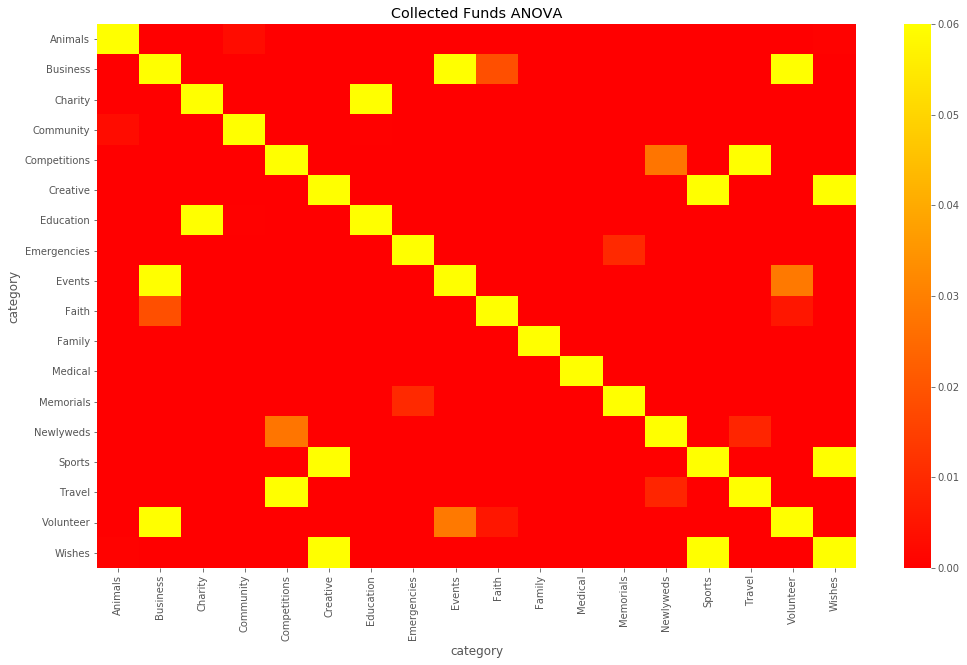

In [38]:
plt.figure(figsize=(17,10))
x = sns.heatmap(p_dsf[3].fillna(1),vmax = .06, fmt="g", cmap='autumn')
x.set_title('Collected Funds ANOVA')
plt.show()